# Field correlations

This notebook contains an example of using xarray for field correlations (the correlation of one time series against the time series data from every point in a field).  In doing so, some of the difficulty in wrestling with different calendar systems and getting our data into a form that allows us to use the xarray correlation function (`xr.corr`) is also demonstrated.

First we import our packages:

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


We're going to read in a monthly time series of the [Southern Oscillation Index (SOI)](https://www.ncei.noaa.gov/access/monitoring/enso/soi), a standardized index measuring the sea level pressure (SLP) difference between Tahiti and Darwin, Australia.  As such, it reflects 'large-scale fluctuations in air pressure between the western and eastern tropical Pacific'.  When the SOI is in a negative phase, there is below normal SLP at Tahiti and above normal SLP at Darwin, indicating coupled atmosphere-ocean conditions associated with El Nino and anomalously warm water in the central and eastern tropical Pacific.  Positive SOI values are associated with La Nina events.  The SOI therefore reflects the tropical atmospheric component of ENSO.  This version of the index comes from the Climate Research Unit at the University of East Anglia (you can see more here: https://crudata.uea.ac.uk/cru/data/soi/).

In [2]:
# read in the soi index as a DataSet
soi = xr.open_dataset("soi.nc",mask_and_scale=True,decode_times=False)

# check the units used for the DataSet
print(soi["time"].attrs["units"]) # this reveals the units to be 'months since 1866-1-15'


months since 1866-01-15


What you'll notice is something that is unfortunately quite common in climate datasets at monthly resolution - the units of time are in 'months since' some datum.  The reason this is unfortunate is that 'month' is imprecisely defined, compared to a day or hour or minute.  Months have different number of days, leap years change the length of months, and some climate data products use 360 day years for simplicity.  Months are kinda a pain in a datetime system, even though _we_ think in months all the time. 

What we're going to do in the code block below is change our 'months since' time coordinate into something that xarray can understand better.  The steps will be this:

* We will create a variable call `new_time` that starts with the datum given above and steps monthly forward in time at the same length as the time coordinate. 
* We will then use `pd.to_datetime` to change this DatetimeIndex into a datetime64 type that xarray will be happier with
* We then remove the soi variable as a DataArray from the DataSet
* Finally, we use `pd.to_datetime` one more time, this time feeding it the current time coordinate but specifying a year-month ("%Y-%m") format.  Essentially, we are overwriting the current time coordinate with the same year and month time coordinates, but "resetting" the days, hours, minutes, seconds, etc. 

Having done this, we will see we have a datetime64 time coordinate with our correct year and month and then days, hours, minutes, etc. all set to midnight on the 1st day of each respective month (e.g. 1866-01-01T00:00:00.000000000). Xarray will be happier with this, believe it or not! 

If you find a more elegant way to do this, please let me know!

In [3]:

## Because 'months' are not a well-defined thing, we need to change the time coordinate if we want to use xr.corr
# create a new monthly-resolution date range starting with the datum and make it as long as the current time coordinate
new_time = pd.date_range(start='1/15/1866',periods=len(soi["time"]),freq='M')

# apply this new time coordinate to our dataset in place of the old one
soi["time"]=pd.to_datetime(new_time)

# remove the SOI from the DataSet into a DataArray - not sure why this is necessary but seems to be for this to work? 
soi = soi["SOI"]

# final step - ensure that the time coordinate is year and month and that everything else is default
soi["time"] = pd.to_datetime(soi["time"].dt.strftime("%Y-%m"))

# take a look!
soi


<xarray.DataArray 'SOI' (time: 1896)>
[1896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1866-01-01 1866-02-01 ... 2023-12-01
Attributes:
    long_name:  CRU Southern Oscillation Index
    units:      1

Let's get a December-February 3 month mean for each year.  Boreal winter is the time where ENSO events canonically peak, so using this season allows us to characterize the mature phase on an El Nino or La Nina event.  We'll take every 3 month average than ends in February to give us DJF averages with the year assigned to the year of the the February.

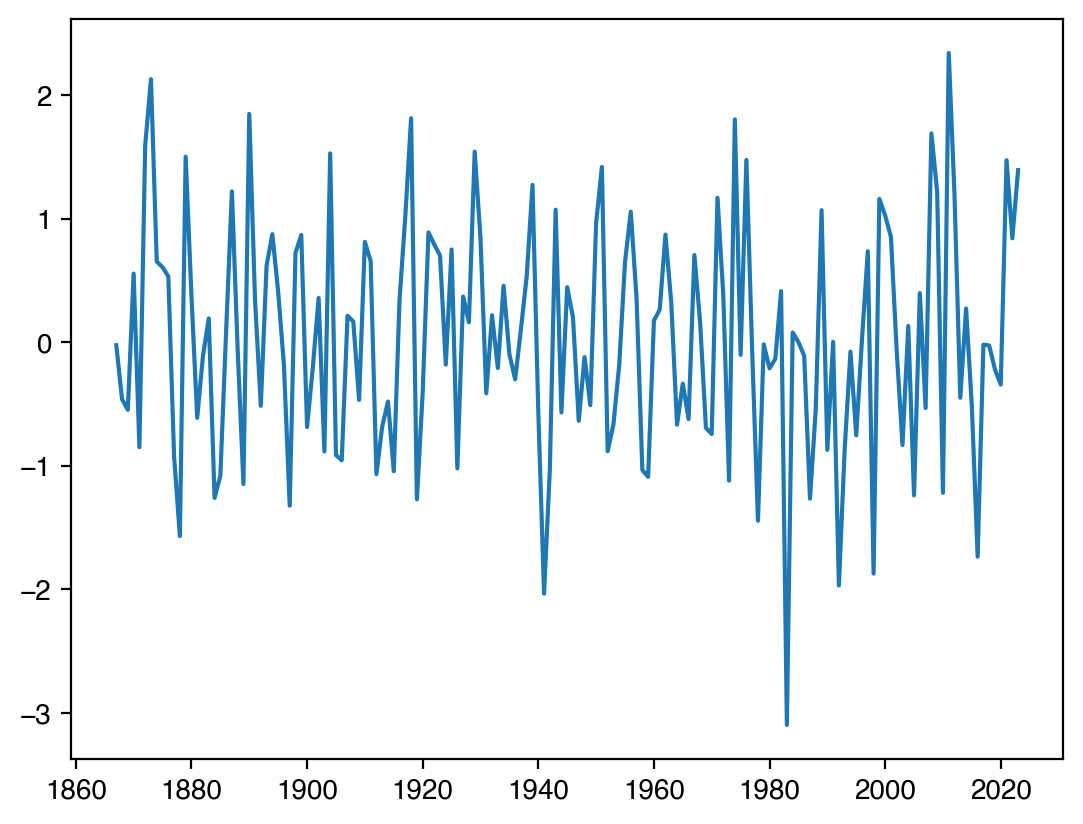

In [4]:
# Calculate the 5-month rolling mean, skipping NaN values
soi_ = soi.rolling(time=3).mean(skipna=True) # 3 months averages

# Select out month 3 (March) to get the average over DJF
djf_soi = soi_[soi_.time.dt.month == 2] # take the 3 month rolling averages ending in February
soi_year = djf_soi.time.dt.year # pull out the time

# do a sanity check
plt.plot(soi_year,djf_soi)

Now, let's get out atmospheric pressure data.  For this example we'll use the 700 millibar geopotential height from the [20th Century Reanalysis](https://www.psl.noaa.gov/data/20thC_Rean/).  The height of the 700 millibar pressure surface is one that is often used to look at atmospheric teleconnections associated with ENSO. We'll no mostly the same procedure on these data - we'll calculate a DJF average value everywhere.  If you look at the time coordinate, you'll see it is _already_ a datetime64 type with year and month and everything else set to midnight on the first day of the month (e.g. 1836-02-01T00:00:00.000000000), so once we get these data ready, we can go ahead and correlate with the SOI we worked on above.  

In [5]:
hgt = xr.open_dataset("hgt.700mb.mon.mean.nc",mask_and_scale=True)
hgt = hgt["hgt"]

# Calculate the 5-month rolling mean, skipping NaN values
hgt_ = hgt.rolling(time=3).mean(skipna=True) # 3 month averages

# Select out month 3 (March) to get the average over DJF
djf_hgt = hgt_[hgt_.time.dt.month == 2] # take averages ending in February
djf_hgt = djf_hgt.squeeze(drop=True) # squeeze out and drop the singleton 'level' dimension
djf_hgt


<xarray.DataArray 'hgt' (time: 180, lat: 181, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[2693.8672, 2693.8672, 2693.8672, ..., 2693.8672, 2693.8672,
         2693.8672],
        [2691.8123, 2691.9326, 2692.0518, ..., 2691.461 , 2691.5757,
         2691.694 ],
        [2688.5146, 2688.8086, 2689.1008, ..., 2687.6335, 2687.9265,
         2688.2175],
...
        [2759.7983, 2759.9375, 2760.0679, ..., 2759.4023, 2759.5405,
         2759.67  ],
        [2760.8062, 2760.8706, 2760.9346, ..., 2760.5906, 2760.6697,
         2760.7344],
        [2762.9307, 2762.9307, 2762.9307, ..., 2762.9307, 2762.9307,
         2762.9307]],

       [[2660.0625, 2660.0625, 2660.0625, ..., 2660.0625, 2660.0625,
         2660.0625],
        [2656.6924, 2656.8154, 2656.971 , ..., 2656.2861, 2656.4182,
         2656.5537],
        [2653.4053, 2653.736 , 2654.0752, ..., 2652.4087, 2652.7358,
         2653.06  ],
        ...,
        [2700.616 , 2700.559 , 2700.4985, ..., 2700.8086, 2700.7493,
         2700.6826],
        [2705.2393, 2705.2007, 2705.1587, ..., 2705.3494, 2705.3193,
         2705.276 ],
        [2710.4082, 2710.4082, 2710.4082, ..., 2710.4082, 2710.4082,
         2710.4082]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1836-02-01 1837-02-01 ... 2015-02-01
Attributes: (12/15)
    long_name:         Monthly Geopotential Height on Pressure Levels
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             m
    GRIB_name:         HGT
    var_desc:          Geopotential height
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    ...                ...
    standard_name:     geopotential_height
    valid_range:       [-1500. 60000.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ -307.88  50208.145]

Now that our data are finally on the same temporal coordinate system, we can use xarray's correlation function (`xr.corr`) to calculate the correlation between the winter SOI and winter 700mb heights.  Because we did all that work on the SOI time coordinate, the SOI time series and the 700mb height field have the same monthly time coordinate formats, and xarray knows enough to match them up with one another for the correlation!

In [6]:
# calculate the field correlation between the soi index and all the 700mb height data along the time dimension
fieldCorrelation = xr.corr(djf_soi,djf_hgt, dim="time")

# check - what does this look like in xarray DataArray format?
fieldCorrelation

<xarray.DataArray (lat: 181, lon: 360)>
array([[-0.13889211, -0.13889211, -0.13889211, ..., -0.13889211,
        -0.13889211, -0.13889211],
       [-0.13366047, -0.13367945, -0.13371576, ..., -0.13358639,
        -0.13361356, -0.13363961],
       [-0.13020082, -0.13026044, -0.13032568, ..., -0.13002612,
        -0.13007637, -0.13012827],
       ...,
       [-0.08071836, -0.08043191, -0.08014145, ..., -0.08161756,
        -0.08130983, -0.08101312],
       [-0.09160667, -0.0914594 , -0.09132505, ..., -0.09203775,
        -0.09189304, -0.0917431 ],
       [-0.10259148, -0.10259148, -0.10259148, ..., -0.10259148,
        -0.10259148, -0.10259148]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

The variable `fieldCorrelation` is an xarray DataArray of Pearson correlation coefficients with latitude and longitude dimensions.  The time coordinate has gone away, because what we're looking at here is the correlation between the DJF SOI time series and the time series of DJF 700 millibar heights at every point on the planet on a 1 degree grid.  It is a map.   

We could just plot this DataArray map of correlations now, actually.  However, when plotting global datasets (including this one), there is often a discontinuity where the longitudinal coordinate system wraps (either at 0 or at 180).  Since Cartopy is the mapping library, it is on it to handle this if it can.  At the moment, Cartopy includes a function to  wrap or add a cyclic point for seamless plotting.  It is a bit clunky in my view, as we have to (at least as far as I can tell?) essentially take our data our of DataArrays to do this (see more here: https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.util.add_cyclic_point.html).  Let's see how this works:

In [7]:
# pull out the function specifically here
from cartopy.util import add_cyclic_point

# also pull out the latitude and longitude, since adding the cyclic point seems alters the field correlation DataArray
field_lon = fieldCorrelation["lon"]
field_lat = fieldCorrelation["lat"]

# usually not necessary, but we can pass an index to the add_cyclic_point to tell it where the longitude coordinate is
idx_lon = fieldCorrelation.dims.index("lon")

# output two new Masked Arrays we can use for plotting 
field_wrap,field_wrap_lon = add_cyclic_point(fieldCorrelation.values,coord=field_lon,axis=idx_lon)

# you'll see the field is now 1 longitude until larger (361 instead of 360):
field_wrap.shape

(181, 361)

With the cyclic point added between the 360 and 0 degree longitude band, we can now go ahead and plot the global field correlation between SOI and 700mb heights:

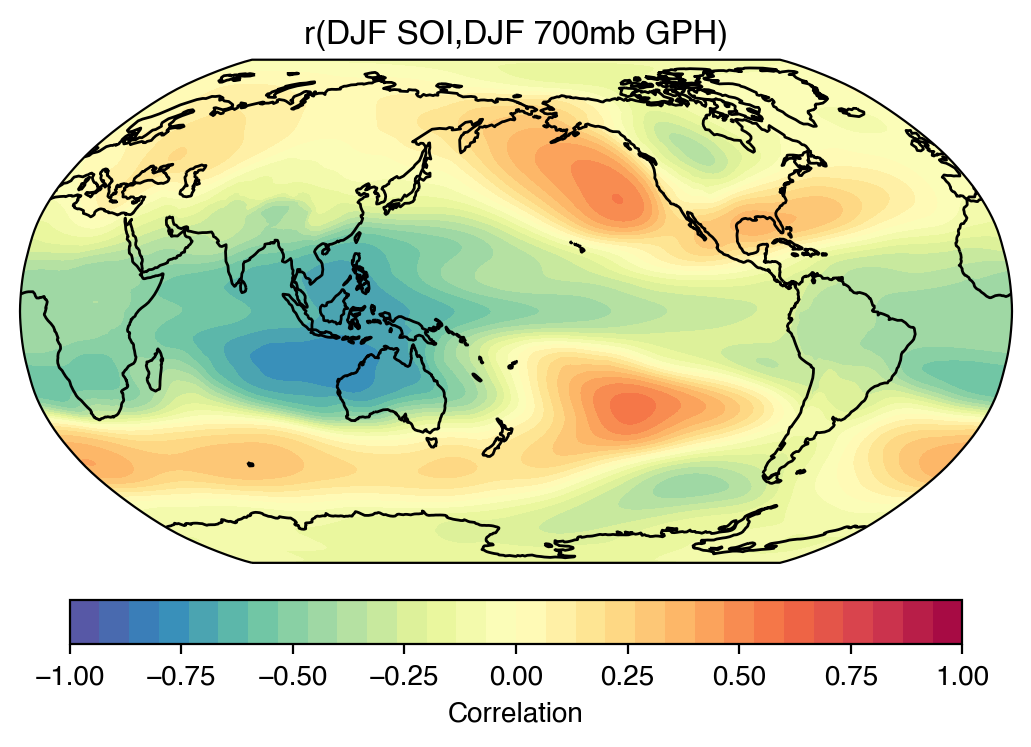

In [8]:
# plot the field correlations
fig, (ax1) = plt.subplots(clear=True,nrows=1,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(field_wrap_lon,field_lat,field_wrap,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

Just for fun, we can make a version where we also plot the locations where the two centers of action of the Southern Oscillation Index -- Tahiti and Darwin, Australia:

Text(130.8444, -16.4637, 'DARWIN')

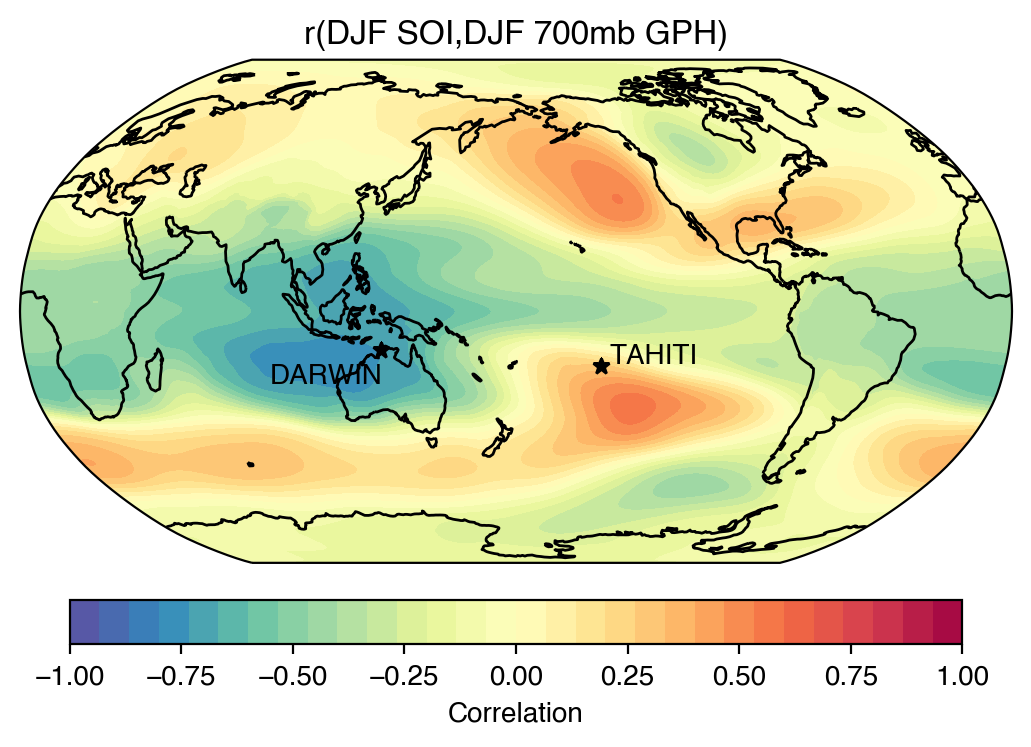

In [9]:
# coordinates as dictionary types:
tahiti = dict(lon=211.4260, lat=-17.6509) 
darwin = dict(lon=130.8444, lat=-12.4637) 

# now plot the field correlations including the location of Tahiti and Darwin
fig, (ax1) = plt.subplots(clear=True,nrows=1,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(field_wrap_lon,field_lat,field_wrap,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

ax1.plot(tahiti["lon"],tahiti["lat"],'k*',transform=ccrs.PlateCarree())
ax1.plot(darwin["lon"],darwin["lat"],'k*',transform=ccrs.PlateCarree())
ax1.text(tahiti["lon"]+3, tahiti["lat"]+1, 'TAHITI', horizontalalignment='left', transform=ccrs.PlateCarree())
ax1.text(darwin['lon'], darwin['lat']-4, 'DARWIN', horizontalalignment='right',verticalalignment="top",transform=ccrs.PlateCarree())

There are other ways to calculate (and plot) the correlation between a single time series and the overlapping (in time) series from a spatial field.  But xarray provides really nice functionality for doing this, as long as you can get both your time series and your field into DataArray formats and make sure the time coordinates have the same calendar and format. 

In the next notebook, we'll look at how to assess the potential significance of the patterns we see in spatial field correlations. 